# Data Engineering Take-Home Assignment: Nature Conservation & Geospatial Data

## Context
Assume you have been hired as a Data Engineer for an organization focused on nature conservation. The organization is working on a project to monitor and protect natural habitats using satellite data, wildlife sensor data, and geospatial information. Your task is to design and implement a data pipeline that ingests, processes, and analyzes this data to help identify areas needing immediate conservation attention as well as build a model that provides helpful insights related our organization's interests.

## Objective 

Your goal in this assessment is to showcase your curiousity and creativity to design rigorous models and derive interesting insights.  

You'll be given two tasks.

The first is a design task, in which we expect you to diagram and describe how you'd set up a process to injest this data from a live streamed source, assuming you are also paying montoring services to supply this data from scratch. Think about how you might transform and store the data efficiently for querying and analysis and feed it into your model. 

The second task will require you devise interesting questions from preliminary explorations of a subset of migration data, found alongside this notebook, and construct a rigorous model to answer them. Please demonstrate all of your process using this notebook, and most importantly your outputs. 




## Tasks

### 1) Design - Data Ingestion & Storage:
- **Ingestion**: Design and implement a solution to ingest data from three different sources: GeoJSON, CSV, and JSON.
- **Automation**: Ensure the pipeline can handle regular data updates (e.g., daily or hourly).
- **Storage**: Choose appropriate storage solutions for each dataset (e.g., relational database, NoSQL, cloud storage, or data lake). Provide justification for your choices.

### 2) Data Transformation & Analysis:
- **Data Parsing & Cleaning**: 
  - Parse and clean the wildlife tracking data (CSV) and geospatial data (GeoJSON) to ensure consistency.
  - Ensure the data is ready for analysis by standardizing formats, removing errors, and handling missing values.

- **Exploratory Data Analysis**:
  - Investigate the data to understand key characteristics, distributions, and trends.

- **Behavioral Analysis**:
  - Identify more complex animal behaviors:
    - Determine when animals cross the boundaries of protected areas.
    - Analyze potential factors contributing to these crossings (e.g., time, weather, or environmental changes).
    - Calculate the total number of animal entries and exits from protected areas over time.

- **Advanced Insights**:
  - Identify migration paths or clustering patterns.
  - Build a predictive model to anticipate future animal movements or identify risk zones for endangered species.

### 3) Optional Bonus - Visualization/Reporting:
- Provide interactive visualizations to demonstrate your analysis, ideally within this notebook.

### Here are data sources you can use to build your analysis. 

- https://storage.googleapis.com/data-science-assessment/animal_events.csv
- https://storage.googleapis.com/data-science-assessment/animals.csv
- https://storage.googleapis.com/data-science-assessment/protected_areas.json
- https://storage.googleapis.com/data-science-assessment/satellites.json

## Deliverables
#### Design component:
- A clear description and diagrams for the architecture and tools you might used, including any cloud services, databases, or libraries (if applicable). During the discussion we'll go over different scenarios. 

#### Implementation:
- Code for the data pipeline that includes:
  - Data ingestion scripts or setup.
  - Transformation and processing logic.
  - Queries or outputs showcasing the results.
- (Optional) a visualization of the results.

## Data
### 1. **Animal Events - CSV** [Download link](https://storage.googleapis.com/data-science-assessment/animal_events.csv)

- Contains data on animal movement events with details like location and speed.
- **Key Columns**: `event_id`, `animal_id`, `timestamp`, `latitude`, `longitude`, `speed`.

---

### 2. **Animals - CSV** [Download link](https://storage.googleapis.com/data-science-assessment/animals.csv)

- Metadata about tracked animals, including species and conservation status.
- **Key Columns**: `animal_id`, `species`, `endangered`, `animal_type`, `preferred_landcover`.

---

### 3. **Protected Areas - GeoJSON** [Download link](https://storage.googleapis.com/data-science-assessment/protected_areas.json)

- Geospatial data representing protected areas with boundaries and metadata.
- **Key Fields**: `name`, `category`, `protected_area_id`, `geometry`.

---

### 4. **Satellite Metadata - JSON** [Download link](https://storage.googleapis.com/data-science-assessment/satellites.json)

- Metadata from satellite imagery, covering factors like cloud cover and resolution.
- **Key Fields**: `satellite_id`, `start_time`, `last_time`, `frequency`, `bounding_box`, `cloud_cover_percentage`, `resolution`.

---

## Evaluation Criteria

- **Data Engineering Skills**: How well the pipeline handles ingestion, transformation, and storage.
- **Geospatial Data Handling**: Ability to process geospatial data and perform spatial operations (e.g., joins, intersections).
- **Scalability & Efficiency**: The pipeline’s ability to handle larger datasets or more frequent updates.
- **Code Quality**: Structure, readability, and use of best practices.
- **Documentation**: Clear explanations of your approach and any assumptions made.
- **Bonus (Visualization/Reporting)**: Extra points for insightful data visualization or reporting.

## Set up

Feel free to set up this notebook using condo, or your own kernal / virtual environment. To make it easier, you can set up the notebook using this docker with the potentialy libraries you might need. 

#### To start using a prepared Docker image, 
- 1 navigate to this shared folder in your terminal, and then load up docker and run the docker file to pull in needed libraries

```bash
docker build -t geospatial-notebook .
docker run -p 8888:8888 -v $(pwd):/home/jovyan/work geospatial-notebook
```


When the container runs, it will display a URL with a token (something like http://127.0.0.1:8888/?token=...). It will probably be something like http://127.0.0.1:8888/tree You can copy this URL into your browser, and you'll open to a Jupyter lab. Your existing notebook will be available inside the container under the work directory.

Anytime you want to work again, just run the following command to start the Docker container and access your notebooks:

```bash
docker run -p 8888:8888 -v $(pwd):/home/jovyan/work geospatial-notebook
```


In [1]:
# Libraries you may or may not need
import pandas as pd
import geopandas as gpd
import shapely
import sqlalchemy

#extra libraries
import requests
from io import StringIO
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
import numpy as np
from sklearn.cluster import DBSCAN
import seaborn as sns

### Task 1: Data preview

Before starting, it is crucial to inspect the first few rows of the data using the head() function. This gives an overview of the structure, data types, and potential inconsistencies. By printing the first rows, we can verify that the data has been correctly read and is in the expected format, which will help prevent issues during later stages of the pipeline.

In [2]:
# URLs for the data sources
animal_events_url = 'https://storage.googleapis.com/data-science-assessment/animal_events.csv'
animals_url = 'https://storage.googleapis.com/data-science-assessment/animals.csv'
protected_areas_url = 'https://storage.googleapis.com/data-science-assessment/protected_areas.json'
satellites_url = 'https://storage.googleapis.com/data-science-assessment/satellites.json'

# Preview animal_events.csv
response = requests.get(animal_events_url)
animal_events = pd.read_csv(StringIO(response.text))
animal_events['timestamp'] = pd.to_datetime(animal_events['timestamp'])
print("Animal Events Data:")
display(animal_events.head())

# Preview animals.csv
response = requests.get(animals_url)
animals = pd.read_csv(StringIO(response.text))
print("\nAnimals Data:")
display(animals.head())

# Preview protected_areas GeoJSON
response = requests.get(protected_areas_url)
protected_areas = gpd.read_file(StringIO(response.text))
print("\nProtected Areas Data:")
display(protected_areas.head())

# Preview satellites.json
response = requests.get(satellites_url)
satellites_data = json.loads(response.text)
satellites_df = pd.json_normalize(satellites_data)
print("\nSatellites Data:")
display(satellites_df.head())

Animal Events Data:


,animal_id,timestamp,latitude,longitude
0,A001,2024-09-01 12:00:00,45.2284,-110.7622
1,A002,2024-09-01 12:00:00,44.5760,-110.6763
2,A003,2024-09-01 12:00:00,44.4232,-111.1061
3,A004,2024-09-01 12:00:00,37.9058,-119.7857
4,A005,2024-09-01 12:00:00,37.7896,-119.6426



Animals Data:


,animal_id,common_name,scientific_name,redlist_cat,megafauna
0,A001,Wolf,Canis lupus,Least Concern,no
1,A002,Bison,Bison bison,Vulnerable,yes
2,A003,Elk,Cervus canadensis,Least Concern,yes
3,A004,Sierra Nevada bighorn sheep,Ovis canadensis sierrae,Endangered,no
4,A005,Sierra Nevada red fox,Vulpes vulpes necator,Critically Endangered,no



Protected Areas Data:


,name,category,protected_area_id,geometry
0,Yellowstone National Park,National Park,PA001,"POLYGON ((-110.839 44.4488, -110.7052 44.599, ..."
1,Yosemite National Park,National Park,PA002,"POLYGON ((-119.655 37.7244, -119.5964 37.6962,..."
2,Grand Canyon National Park,National Park,PA003,"POLYGON ((-112.1861 36.1336, -112.2156 36.2331..."



Satellites Data:


,satellite_id,start_time,last_time,frequency,cloud_cover_percentage,resolution,bounding_box.xmin,bounding_box.ymin,bounding_box.xmax,bounding_box.ymax
0,SAT001,2018-09-01T12:00:00Z,2024-09-10T12:00:00Z,daily,12.5,10m,-112.939131,42.596356,-107.048726,46.142424
1,SAT002,2004-09-01T12:00:00Z,2024-09-06T12:00:00Z,bi-weekly,10.0,100m,-180.000000,-90.000000,180.000000,90.000000
2,SAT003,2022-09-01T12:00:00Z,2024-09-10T12:00:00Z,hourly,10.0,20m,-124.178099,30.738207,-95.942831,51.538929


#### Data Ingestion & Storage


I chose a relational database for storing the data because it handles structured, relational data efficiently, which aligns with our datasets (e.g., animal events, species metadata, and protected areas). Relational databases ensure data integrity, support complex queries, and scale well with indexing. They also offer geospatial capabilities (PostGIS) essential for analyzing animal movements in protected areas.

Data lakes may be better for handling large volumes of unstructured or semi-structured data, but they lack the same level of relational integrity and query efficiency for structured datasets.

In [3]:
# We will be using a postgres database to store our data from multiple sources
# Prerequesites: 
# 1. Postgres 16 with the PostGIS extension installed on your machine
# 2. Create a local database called 'assignment' accessible on port '5433' with username 'postgres' and password 'postgres'

# Connect to your database
db_username = 'postgres'  
db_password = 'postgres'
db_host = 'localhost'
db_port = '5433'
db_name = 'assignment'

conn_string = f'postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{db_name}' # Create connection string
engine = sqlalchemy.create_engine(conn_string) # Create database engine using sqlalchemy

In this process, I defined functions to ingest data from four different sources (CSV, GeoJSON, and JSON) by downloading the data via URLs. For the animal events and animals data, I fetched and processed the CSV files, ensuring the timestamps were in the correct format and removing duplicates. For protected areas, I processed the GeoJSON data to ensure a consistent coordinate reference system (EPSG:4326) before storing it in PostGIS. Finally, I processed the satellite data by converting it from JSON format into a DataFrame, before storing all datasets into a PostgreSQL database for further analysis.

In [4]:
# For each data source, we define a function to ingest the data into the database

# Ingest animal_events.csv
def ingest_animal_events(url):
    response = requests.get(url)
    animal_events = pd.read_csv(StringIO(response.text))  # Read CSV data from the response
    animal_events['timestamp'] = pd.to_datetime(animal_events['timestamp'])  # Ensure proper datetime format
    animal_events.to_sql('animal_events', engine, if_exists='replace', index=False)  # Store in PostgreSQL

# Ingest animals.csv
def ingest_animals(url):
    response = requests.get(url)
    animals = pd.read_csv(StringIO(response.text))  # Read CSV data from the response
    animals.drop_duplicates(subset='animal_id', inplace=True)  # Clean and transform data
    animals.to_sql('animals', engine, if_exists='replace', index=False)  # Store in PostgreSQL

# Ingest protected_areas
def ingest_protected_areas(url):
    response = requests.get(url)
    protected_areas = gpd.read_file(response.text)  # Read GeoJSON data from the response
    protected_areas = protected_areas.to_crs(epsg=4326)  # Ensure consistent Coordinate Reference System (crs)
    protected_areas.to_postgis('protected_areas', engine, if_exists='replace', index=False)  # Store in PostGIS

# Ingest satellites
def ingest_satellites(url):
    response = requests.get(url)
    satellites_data = json.loads(response.text)  # Read JSON data from the response
    satellites_df = pd.json_normalize(satellites_data)  # Convert JSON to DataFrame
    satellites_df.to_sql('satellites', engine, if_exists='replace', index=False)  # Store in PostgreSQL

# Execute the data ingestion
ingest_animal_events(animal_events_url)
ingest_animals(animals_url)
ingest_protected_areas(protected_areas_url)
ingest_satellites(satellites_url)

### Task 2: Data Transformation & Analysis


#### 2.1 Parse and Clean the Data


In this process, I first loaded the animal events data from the database, converting the timestamp to a datetime format and ensuring the data points have valid latitude and longitude coordinates by converting them into a GeoDataFrame. I adjusted the timestamps to account for the local solar time based on longitude and converted them to UTC. For protected areas, I loaded and ensured the data used the correct coordinate reference system (EPSG:4326). I cleaned the animals data by removing duplicates, and for the satellite data, I converted the start and end times to a proper datetime format to facilitate time-based analysis.

In [5]:
#### animal_events ####
animal_events = pd.read_sql('SELECT * FROM animal_events', engine) # Load data
animal_events['timestamp'] = pd.to_datetime(animal_events['timestamp']) # Convert timestamp to datetime
animal_events.dropna(subset=['latitude', 'longitude'], inplace=True)
geometry = [shapely.geometry.Point(xy) for xy in zip(animal_events['longitude'], animal_events['latitude'])] # Convert to a GeoDataFrame
animal_events_gdf = gpd.GeoDataFrame(animal_events, geometry=geometry, crs='EPSG:4326')

# In order to work with the data, we need to ensure that the timestamps are in the correct format and time zone.
# we will adjust the timestamp to local solar time and convert to UTC format
def adjust_timestamp_to_local_and_utc(row):
    longitude = row['longitude'] # Get the longitude
    offset_minutes = longitude * 4 # Calculate the time offset in minutes (4 minutes per degree of longitude)
    local_time = row['timestamp'] + pd.Timedelta(minutes=offset_minutes) # Adjust the timestamp to local solar time
    utc_time = local_time.tz_localize('UTC') # Convert to UTC and set timezone to UTC
    return utc_time

animal_events_gdf['timestamp'] = animal_events_gdf.apply(adjust_timestamp_to_local_and_utc, axis=1)


#### protected_areas ####
protected_areas_gdf = gpd.read_postgis('SELECT * FROM protected_areas', engine, geom_col='geometry') # Load data
protected_areas_gdf = protected_areas_gdf.to_crs(epsg=4326) # Ensure correct CRS

#### animals ####
animals_df = pd.read_sql('SELECT * FROM animals', engine) # Load data
animals_df.drop_duplicates(subset=['animal_id'], inplace=True) # Drop duplicates and handle missing values

#### satellites ####
satellite_df = pd.read_sql('SELECT * FROM satellites', engine)
satellite_df['start_time'] = pd.to_datetime(satellite_df['start_time']) # Convert timestamps to datetime
satellite_df['last_time'] = pd.to_datetime(satellite_df['last_time'])

# display dataframes
display('animal_events_gdf', animal_events_gdf.head(1),'protected_areas_gdf', protected_areas_gdf.head(1),'animals_df', animals_df.head(1),'satellite_df', satellite_df.head(1))

'animal_events_gdf'

,animal_id,timestamp,latitude,longitude,geometry
0,A001,2024-09-01 04:36:57.072000+00:00,45.2284,-110.7622,POINT (-110.7622 45.2284)


'protected_areas_gdf'

,name,category,protected_area_id,geometry
0,Yellowstone National Park,National Park,PA001,"POLYGON ((-110.839 44.4488, -110.7052 44.599, ..."


'animals_df'

,animal_id,common_name,scientific_name,redlist_cat,megafauna
0,A001,Wolf,Canis lupus,Least Concern,no


'satellite_df'

,satellite_id,start_time,last_time,frequency,cloud_cover_percentage,resolution,bounding_box.xmin,bounding_box.ymin,bounding_box.xmax,bounding_box.ymax
0,SAT001,2018-09-01 12:00:00+00:00,2024-09-10 12:00:00+00:00,daily,12.5,10m,-112.939131,42.596356,-107.048726,46.142424


#### 2.2 Exploratory Data Analysis

I merged the animal movement data (animal_events_gdf) with the animal metadata (animals_df) to include species and conservation status for each movement. I then plotted two bar charts: one showing the distribution of animal movements by species and another showing movements by conservation status.

For the spatial analysis, I created a global map plotting animal movements with unique colors for each species, while overlaying protected area boundaries. Protected areas were labeled on the map, and a customized legend was added to distinguish between species movements and protected areas.

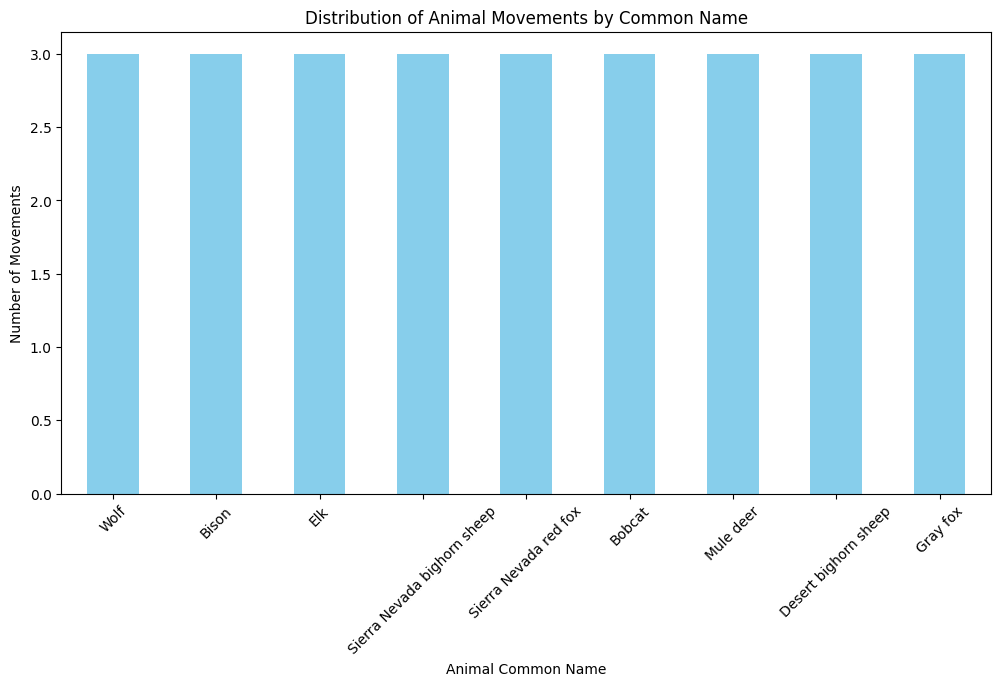

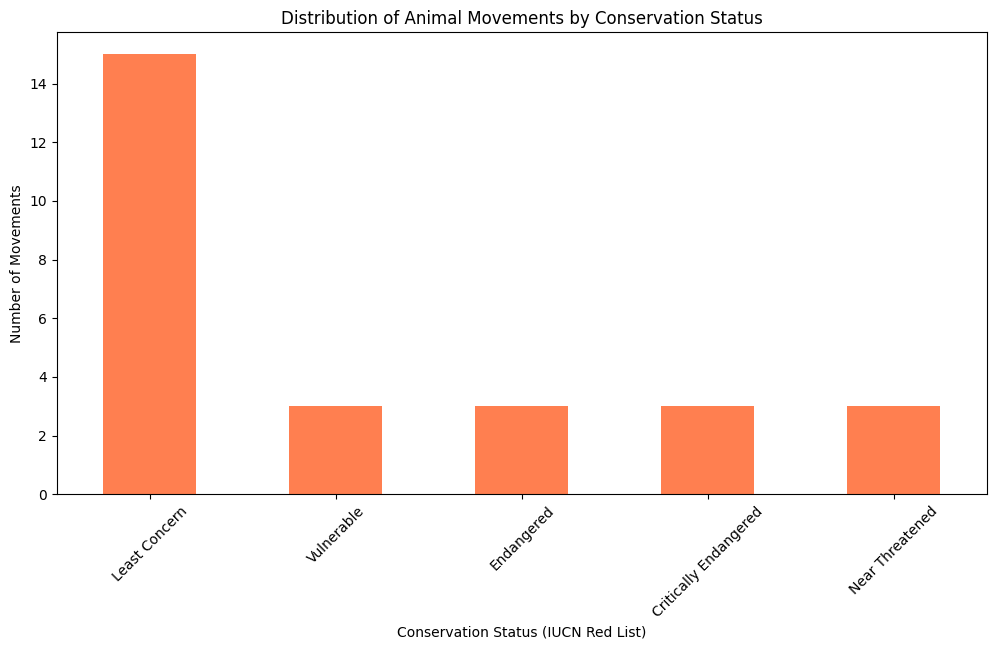

/var/folders/1g/rwnkwjjs0w9_xcc0cwsf40dw0000gn/T/ipykernel_64820/1592264341.py:59: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


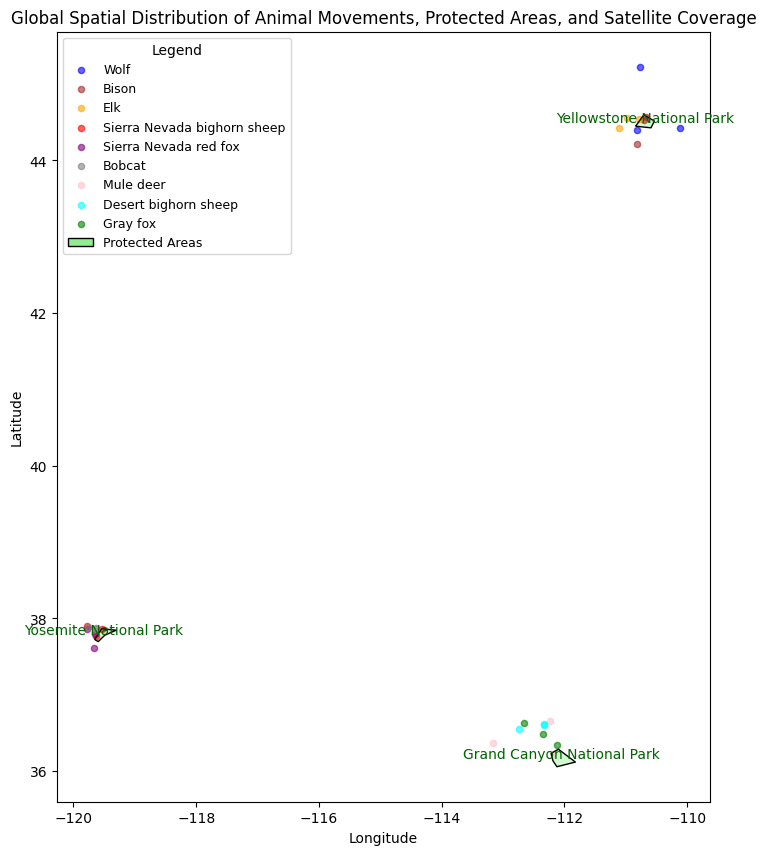

In [6]:
# Merge animal events with animal metadata
merged_df = animal_events_gdf.merge(animals_df, on='animal_id')

# Plot the distribution of animal movements by common name
common_name_counts = merged_df['common_name'].value_counts()
common_name_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Distribution of Animal Movements by Common Name')
plt.xlabel('Animal Common Name')
plt.ylabel('Number of Movements')
plt.xticks(rotation=45)
plt.show()


# Plot the distribution of animal movements by conservation status
redlist_counts = merged_df['redlist_cat'].value_counts()
redlist_counts.plot(kind='bar', figsize=(12, 6), color='coral')
plt.title('Distribution of Animal Movements by Conservation Status')
plt.xlabel('Conservation Status (IUCN Red List)')
plt.ylabel('Number of Movements')
plt.xticks(rotation=45)
plt.show()


# Ensure animal_events_gdf is merged with animals_df to include the 'common_name' column if not already merged
animal_events_gdf = animal_events_gdf.merge(animals_df, on='animal_id', how='left')

# Plot the global view
fig, ax = plt.subplots(figsize=(14, 10))

# Unique colors for each animal species
animal_colors = {
    'Wolf': 'blue',
    'Bison': 'brown',
    'Elk': 'orange',
    'Sierra Nevada bighorn sheep': 'red',
    'Sierra Nevada red fox': 'purple',
    'Bobcat': 'gray',
    'Mule deer': 'pink',
    'Desert bighorn sheep': 'cyan',
    'Gray fox': 'green'
}

# Plot protected areas with labels
protected_areas_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
protected_areas_gdf.plot(ax=ax, color='lightgreen', alpha=0.4, label='Protected Areas')
for idx, row in protected_areas_gdf.iterrows():
    plt.annotate(text=row['name'], xy=(row.geometry.centroid.x, row.geometry.centroid.y),
                 horizontalalignment='center', fontsize=10, color='darkgreen')

# Plot animal movements differentiated by species
for species, color in animal_colors.items():
    subset = animal_events_gdf[animal_events_gdf['common_name'] == species]
    subset.plot(ax=ax, markersize=20, color=color, label=species, alpha=0.6, marker='o')

# Add legend entries for protected areas
protected_area_patch = mpatches.Patch(facecolor='lightgreen', edgecolor='black', label='Protected Areas')

# Customize the legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicates in legend
plt.legend(handles=list(by_label.values()) + [protected_area_patch], 
           loc='upper left', fontsize=9, title='Legend')

# Plot title and labels
plt.title('Global Spatial Distribution of Animal Movements, Protected Areas, and Satellite Coverage')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

#### Analysis

The data shows an equal number of movements for each species, indicating that movement data is evenly distributed across the species in the dataset. 
However, despite the dataset’s small size, it still offers a representative distribution of conservation statuses, with more movements associated with species of Least Concern. 
This reflects a typical pattern, where more common species tend to have more recorded movements, while species with vulnerable statuses, though present, are less frequent in the dataset.

#### 2.3 Behavioral Analysis

##### Determine when animals cross the boundaries of protected areas.

I performed a spatial join to identify animal entries into protected areas by matching animal movements with protected area boundaries. Then, I grouped the data by protected area and species to count crossings. Finally, I created a stacked bar plot showing the number of crossings per protected area, with sub-bars for each species.

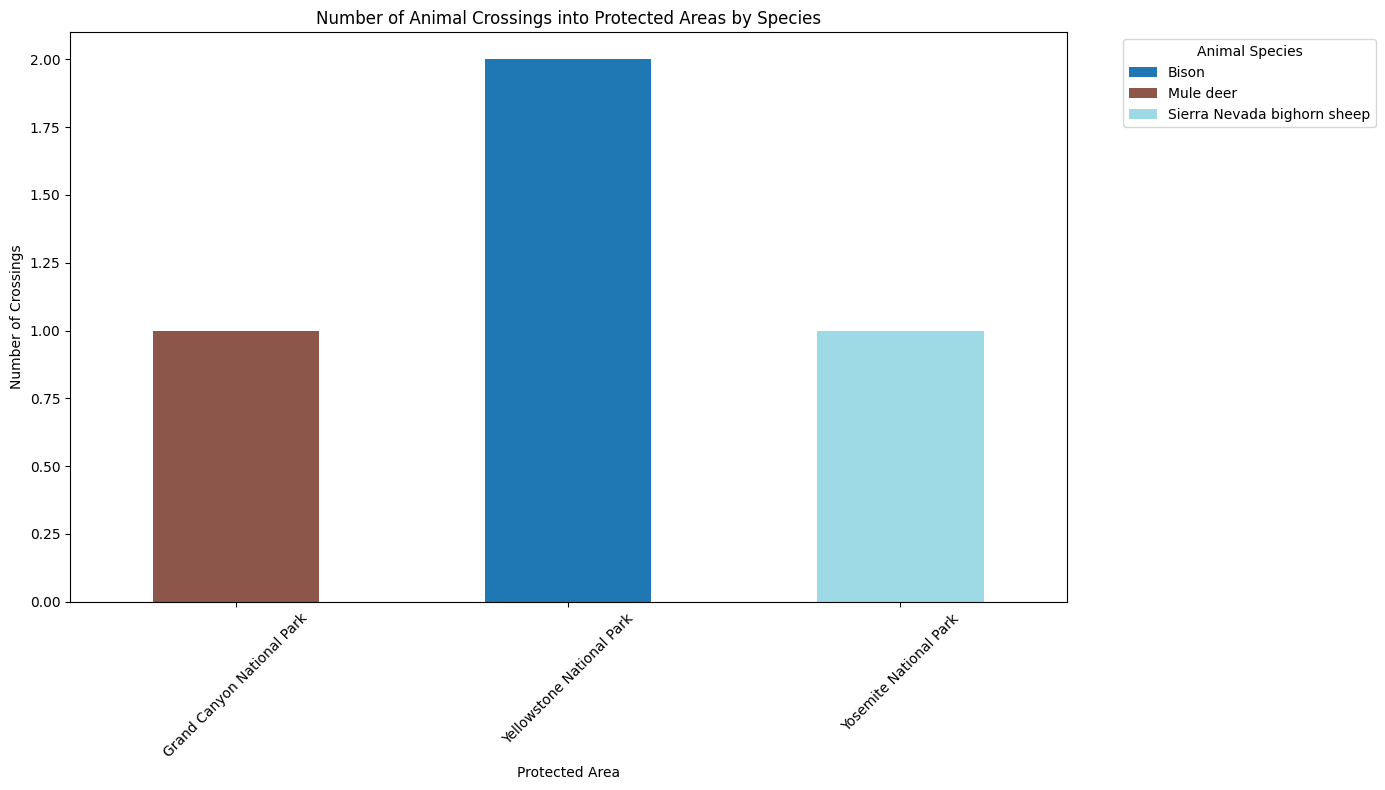

In [7]:
# Perform spatial join to determine animal entries into protected areas
crossings = gpd.sjoin(animal_events_gdf, protected_areas_gdf, how='inner', predicate='within')

# Group by protected area name and common name to count the number of crossings
crossings_grouped = crossings.groupby(['name', 'common_name']).size().unstack(fill_value=0)

# Plot the number of crossings per protected area with sub-bars for each common name
crossings_grouped.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Number of Animal Crossings into Protected Areas by Species')
plt.xlabel('Protected Area')
plt.ylabel('Number of Crossings')
plt.xticks(rotation=45)

# Add legend and show the plot
plt.legend(title='Animal Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Analysis

This limited diversity of species crossing the protected area boundaries is likely due to the small dataset. In a more extensive dataset, we would expect to see a wider variety of species crossing into or out of these areas. The current data only captures a single species’ movement per park, which limits the ability to draw broader conclusions about animal behavior across different species.

##### Analyze potential factors contributing to these crossings (e.g., time, weather, or environmental changes).

In this process, I designed a function to fetch satellite data relevant to each animal crossing event based on both the event’s timestamp and location. The function first filters satellite data by the time overlap (matching the event’s timestamp within the satellite’s coverage period). Then, it checks if the event’s location falls within the satellite’s bounding box. If relevant satellite data exists, it calculates and returns the average cloud cover percentage from those satellites.

After calculating the cloud cover percentage for each crossing, I proceeded with a temporal analysis by extracting the hour and month of the crossing events to explore daily and seasonal patterns. I created bar plots to show the distribution of animal crossings based on the hour of the day and month.

Next, I analyzed the impact of weather on crossings by visualizing the distribution of cloud cover during the crossings and plotting cloud cover percentage against the time of day for different animal species.

Finally, I performed a basic statistical analysis of cloud cover during crossings and calculated the correlation between cloud cover percentage and the time of day (hour) to identify any relationship between weather and crossing times.

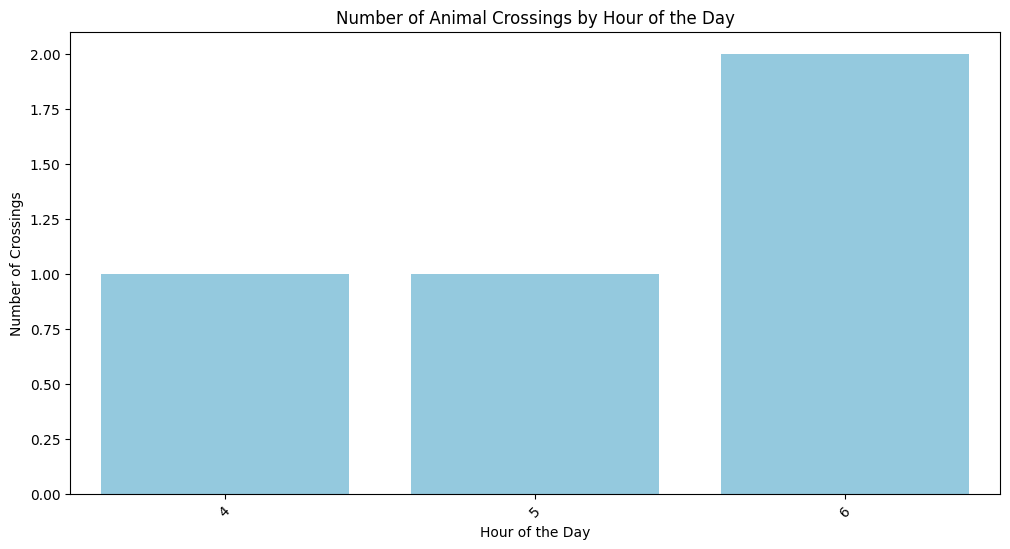

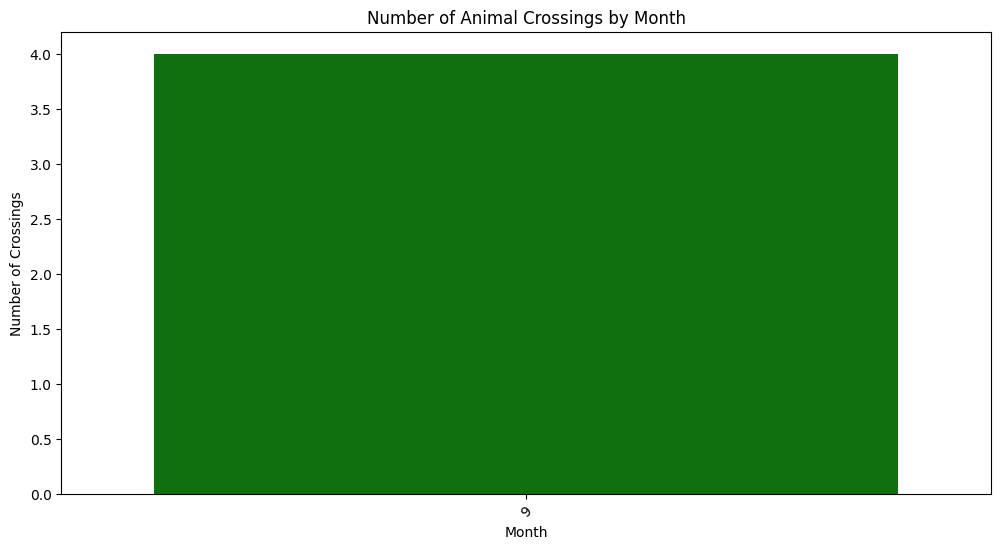

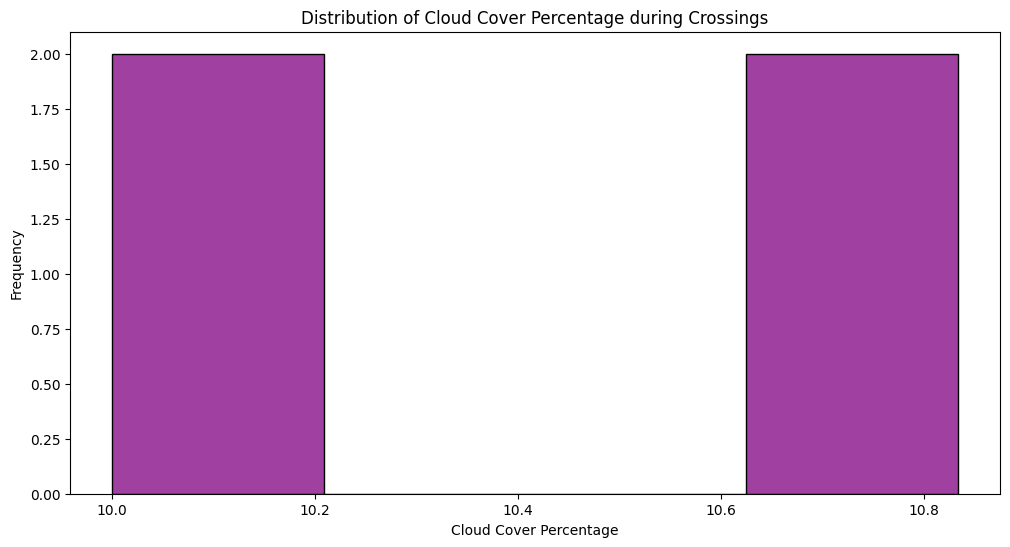

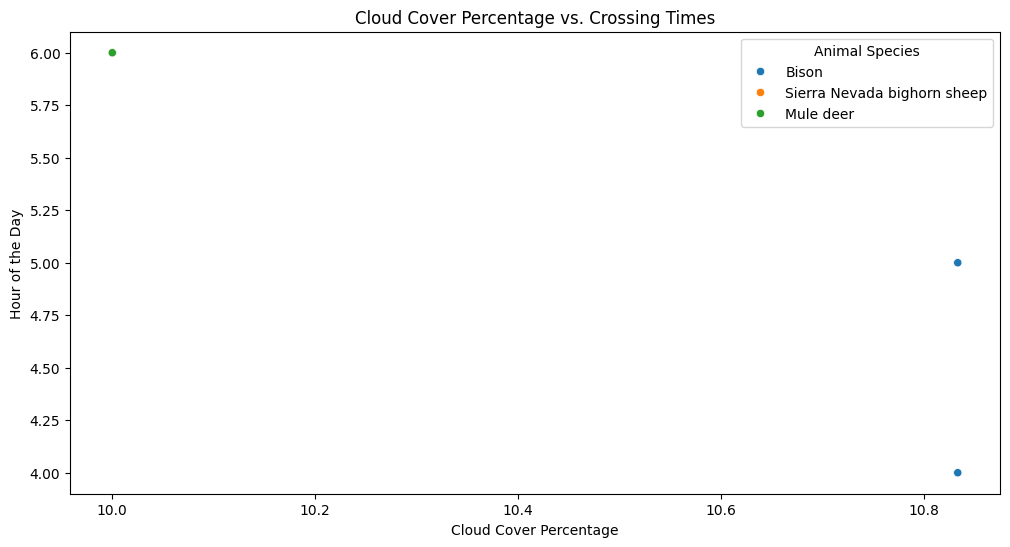

Statistics for Cloud Cover Percentage during Crossings:
count     4.000000
mean     10.416667
std       0.481125
min      10.000000
25%      10.000000
50%      10.416667
75%      10.833333
max      10.833333
Name: cloud_cover_percentage, dtype: float64

Correlation between Cloud Cover Percentage and Hour of the Day: -0.9045340337332909


In [8]:
# Define a function to get satellite info overlapping with animal event times and locations
def get_satellite_info(event_time, event_geometry, satellites):
    # Filter satellites by time overlap
    relevant_satellites = satellites[
        (satellites['start_time'] <= event_time) & 
        (satellites['last_time'] >= event_time)
    ]

    # Further filter by spatial overlap (event within satellite's bounding box)
    relevant_satellites = relevant_satellites[
        (relevant_satellites['bounding_box.xmin'] <= event_geometry.x) &
        (relevant_satellites['bounding_box.xmax'] >= event_geometry.x) &
        (relevant_satellites['bounding_box.ymin'] <= event_geometry.y) &
        (relevant_satellites['bounding_box.ymax'] >= event_geometry.y)
    ]

    # Return the mean cloud cover percentage if there are relevant satellites
    return relevant_satellites['cloud_cover_percentage'].mean() if not relevant_satellites.empty else None

# Ensure timestamps are timezone-aware
crossings['timestamp'] = crossings['timestamp'].dt.tz_convert('UTC')  # Ensure timestamps are in UTC

# Add satellite cloud cover percentage to the crossings DataFrame
crossings['cloud_cover_percentage'] = crossings.apply(
    lambda row: get_satellite_info(row['timestamp'], row['geometry'], satellite_df), axis=1
)

# 1. Temporal Patterns
# Extract hour and month to analyze time of day and seasonal patterns
crossings['hour'] = crossings['timestamp'].dt.hour
crossings['month'] = crossings['timestamp'].dt.month

# Plot number of crossings by hour of the day
plt.figure(figsize=(12, 6))
sns.countplot(data=crossings, x='hour', color='skyblue')
plt.title('Number of Animal Crossings by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crossings')
plt.xticks(rotation=45)
plt.show()

# Plot number of crossings by month
plt.figure(figsize=(12, 6))
sns.countplot(data=crossings, x='month', color='green')
plt.title('Number of Animal Crossings by Month')
plt.xlabel('Month')
plt.ylabel('Number of Crossings')
plt.xticks(rotation=45)
plt.show()

# 2. Weather Impact (Cloud Cover)
# Plot crossings by cloud cover percentage
plt.figure(figsize=(12, 6))
sns.histplot(crossings['cloud_cover_percentage'].dropna(), bins=4, color='purple')
plt.title('Distribution of Cloud Cover Percentage during Crossings')
plt.xlabel('Cloud Cover Percentage')
plt.ylabel('Frequency')
plt.show()

# Plot cloud cover percentage vs number of crossings
plt.figure(figsize=(12, 6))
sns.scatterplot(data=crossings, x='cloud_cover_percentage', y='hour', hue='common_name', palette='tab10')
plt.title('Cloud Cover Percentage vs. Crossing Times')
plt.xlabel('Cloud Cover Percentage')
plt.ylabel('Hour of the Day')
plt.legend(title='Animal Species')
plt.show()

# 3. Statistical Analysis
# Calculate basic statistics for cloud cover
cloud_cover_stats = crossings['cloud_cover_percentage'].describe()
print("Statistics for Cloud Cover Percentage during Crossings:")
print(cloud_cover_stats)

# Check correlation between cloud cover and crossing time (hour)
correlation = crossings['cloud_cover_percentage'].corr(crossings['hour'])
print("\nCorrelation between Cloud Cover Percentage and Hour of the Day:", correlation)

#### Analysis

1. Crossings by Hour of the Day 
he bar chart shows that animal crossings are most frequent around 6 AM, with some activity observed around 4 AM and 5 AM. This indicates that animal movements are more likely to occur in the early morning hours, potentially right before or during sunrise. These findings support the idea that animals may move during the cooler, darker hours of early morning, perhaps for feeding or transitioning between different habitats.

2. Crossings by Month 
All recorded crossings occurred in September, showing no variation across other months. This is due to the limited dataset for this specific period, but it suggests that during this month, animals might be more active near or within the protected areas.

3. Cloud Cover Percentage
Most crossings happening when the cloud cover was around 10%.
The scatter plot shows the relationship between cloud cover percentage and crossing times. All crossings occurred under similar cloud cover conditions (10-10.8%), indicating no significant variability in animal behavior relative to cloud cover. The influence of time and weather is interrelated (strong negative correlation), animals tend to cross early in the morning when cloud cover is consistently at this level. This suggests that weather conditions around this time of day are relatively stable, which could be another reason why animals prefer to move during these hours.


##### Calculate the total number of animal entries and exits from protected areas over time.

In this process, I sorted the animal events data by animal_id and timestamp to ensure events are processed chronologically. For each animal, I tracked whether it was inside or outside a protected area at each event. When the animal entered or exited a protected area, I logged the event as either an ‘entry’ or ‘exit’. The collected entry and exit data were stored in a DataFrame, which was then used to calculate and visualize the total number of entries and exits over time. A stacked bar plot was generated to show the frequency of animal crossings into and out of protected areas.

<Figure size 1400x800 with 0 Axes>

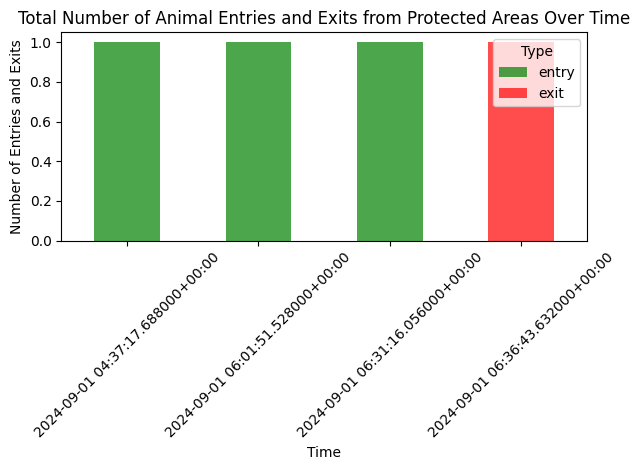

,timestamp,animal_id,type
0,2024-09-01 04:37:17.688000+00:00,A002,entry
1,2024-09-01 06:36:43.632000+00:00,A002,exit
2,2024-09-01 06:01:51.528000+00:00,A004,entry
3,2024-09-01 06:31:16.056000+00:00,A007,entry


In [9]:
# Sort animal events by animal_id and timestamp to process chronologically
animal_events_gdf_sorted = animal_events_gdf.sort_values(by=['animal_id', 'timestamp'])

# Initialize a DataFrame to track entries and exits
entries_exits_data = {
    'timestamp': [],
    'animal_id': [],
    'type': []  # 'entry' or 'exit'
}

# Determine entries and exits for each animal
for animal_id, group in animal_events_gdf_sorted.groupby('animal_id'):
    inside_protected_area = False  # Track whether the animal is inside a protected area
    
    for idx, event in group.iterrows():
        # Check if the current event is inside any protected area
        is_inside = protected_areas_gdf.contains(event['geometry']).any()

        if is_inside and not inside_protected_area:
            # Entry detected
            entries_exits_data['timestamp'].append(event['timestamp'])
            entries_exits_data['animal_id'].append(animal_id)
            entries_exits_data['type'].append('entry')
            inside_protected_area = True

        elif not is_inside and inside_protected_area:
            # Exit detected
            entries_exits_data['timestamp'].append(event['timestamp'])
            entries_exits_data['animal_id'].append(animal_id)
            entries_exits_data['type'].append('exit')
            inside_protected_area = False

# Convert the entries_exits_data to a DataFrame
entries_exits_df = pd.DataFrame(entries_exits_data)

# Calculate the total number of entries and exits over time
entries_exits_count = entries_exits_df.groupby(['timestamp', 'type']).size().unstack(fill_value=0)
entries_exits_count['total'] = entries_exits_count.sum(axis=1)

# Plot the total number of entries and exits over time
plt.figure(figsize=(14, 8))
entries_exits_count[['entry', 'exit']].plot(kind='bar', stacked=True, color=['green', 'red'], alpha=0.7)
plt.title('Total Number of Animal Entries and Exits from Protected Areas Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Entries and Exits')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.tight_layout()
plt.show()

# Display the total counts
entries_exits_df.head()

#### Analysis

The majority of animal entries into the protected area occur between 4:30 AM and 6:30 AM. This suggests that animals tend to enter the protected area during the late night or early morning, which might indicate that they are using the area as a safe resting or feeding zone during the nighttime hours.

Dawn Exit: The single exit observed around 6:36 AM suggests that animals may leave the protected area as dawn breaks. This behavior could be related to the animals completing their nocturnal activities and beginning their daily movements or migrations as daylight approaches.

Behavioral Insight:
The timing of these entries and exits aligns with common nocturnal animal behaviors. Many species tend to be more active during the night for foraging or avoiding predators. They enter protected areas during these hours for safety or access to resources.

#### 2.4 Advanced Insights

##### Identify migration paths or clustering patterns.


Best parameters for Cluster 1 (Yellowstone): eps=0.182, min_samples=2, clusters=2
Best parameters for Cluster 2 (Yosemite): eps=0.032, min_samples=2, clusters=3
Best parameters for Cluster 3 (Grand Canyon): eps=0.132, min_samples=2, clusters=3


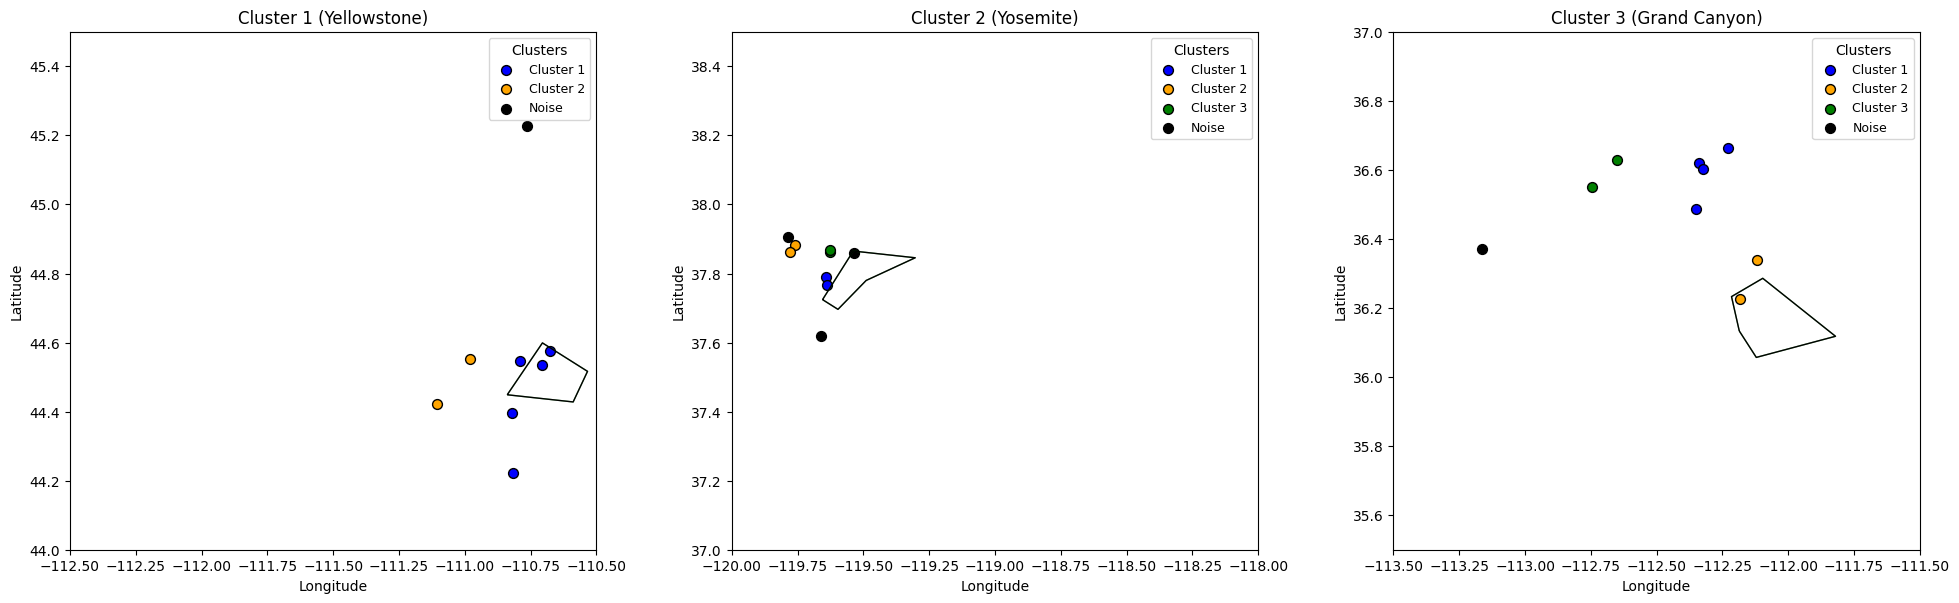

In [10]:
# Define the coordinate ranges for each cluster
cluster_ranges = [
    {'xlim': (-112.5, -110.5), 'ylim': (44.0, 45.5), 'title': 'Cluster 1 (Yellowstone)'},
    {'xlim': (-120.0, -118.0), 'ylim': (37.0, 38.5), 'title': 'Cluster 2 (Yosemite)'},
    {'xlim': (-113.5, -111.5), 'ylim': (35.5, 37.0), 'title': 'Cluster 3 (Grand Canyon)'}
]

# Hyperparameter grid for DBSCAN
eps_values = np.arange(0.002, 3, 0.01)  # Range of eps values
min_samples_values = range(2, 10)        # Range of min_samples values

def perform_dbscan_grid_search(coords):
    """ Perform DBSCAN with grid search over eps and min_samples and return the best model """
    best_model = None
    best_num_clusters = -1  # Initialize with no clusters found
    best_eps = None
    best_min_samples = None
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=min_samples).fit(coords)
            labels = db.labels_
            
            # Calculate the number of clusters (excluding noise points with label -1)
            num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            num_noise = list(labels).count(-1)
            
            # Choose model with the most clusters (we want at least 2) and low noise
            if num_clusters > best_num_clusters and num_clusters > 1 and num_noise < len(coords) * 0.5:
                best_model = db
                best_num_clusters = num_clusters
                best_eps = eps
                best_min_samples = min_samples
    
    return best_model, best_eps, best_min_samples, best_num_clusters

# Create subplots for each cluster
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Colors for clusters (max of 10 clusters) and noise
cluster_colors = ListedColormap(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'])
noise_color = 'black'

# Iterate over each cluster
for i, cluster in enumerate(cluster_ranges):
    ax = axs[i]

    # Filter animal events within the cluster bounds
    in_cluster = (
        (animal_events_gdf['longitude'] >= cluster['xlim'][0]) &
        (animal_events_gdf['longitude'] <= cluster['xlim'][1]) &
        (animal_events_gdf['latitude'] >= cluster['ylim'][0]) &
        (animal_events_gdf['latitude'] <= cluster['ylim'][1])
    )

    # Extract coordinates for clustering within this cluster
    cluster_coords = animal_events_gdf.loc[in_cluster, ['longitude', 'latitude']].to_numpy()

    # Perform grid search and find the best DBSCAN model for this cluster
    if len(cluster_coords) > 0:
        best_model, best_eps, best_min_samples, best_num_clusters = perform_dbscan_grid_search(cluster_coords)

        # Check if a valid model was returned
        if best_model is not None:
            animal_events_gdf.loc[in_cluster, 'cluster'] = best_model.labels_
            # Log the best parameters for each cluster
            print(f"Best parameters for {cluster['title']}: eps={best_eps}, min_samples={best_min_samples}, clusters={best_num_clusters}")
        else:
            # Assign -1 (noise) if no valid clustering was found
            animal_events_gdf.loc[in_cluster, 'cluster'] = -1

    # Plot the cluster results
    labels = animal_events_gdf.loc[in_cluster, 'cluster']
    
    # Plot each cluster with a different color
    for cluster_label in set(labels):
        if cluster_label == -1:
            # Noise points
            color = noise_color
            label = 'Noise'
        else:
            # Cluster points
            color = cluster_colors(int(cluster_label))
            label = f'Cluster {int(cluster_label)+ 1}'
        
        # Plot points for the current cluster
        ax.scatter(
            animal_events_gdf.loc[in_cluster & (labels == cluster_label), 'longitude'],
            animal_events_gdf.loc[in_cluster & (labels == cluster_label), 'latitude'],
            color=color, label=label, s=50, edgecolor='k'
        )

    # Plot protected areas on top of clusters
    protected_areas_gdf.boundary.plot(ax=ax, color='black', linewidth=1)  # Boundary of protected areas
    protected_areas_gdf.plot(ax=ax, color='none', edgecolor='green', alpha=0.5)  # Protected area outlines
    
    # Set limits and titles for each subplot
    ax.set_xlim(cluster['xlim'])
    ax.set_ylim(cluster['ylim'])
    ax.set_title(cluster['title'])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Create legend for each subplot
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=9, title='Clusters')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Analysis

In this analysis, we applied DBSCAN clustering to animal movement data in three national parks: Yellowstone, Yosemite, and Grand Canyon. The goal was to identify clusters of animal movements within each park and nearby regions, and to detect potential outliers or noise in the data. A grid search was performed to find the best eps (distance threshold) and min_samples (minimum points to form a cluster) for each national park.

Cluster 1 (Yellowstone):
- Animal movements in the Yellowstone region formed two distinct clusters. The protected area is located near some of the clustered points, indicating that animal activities are concentrated around the park boundary. There is some noise detected, possibly indicating sparse or scattered movements.

Cluster 2 (Yosemite):
- Yosemite shows three well-defined clusters of animal movement, indicating more dispersed activity within the region. The clusters are fairly close to the protected area boundary. Noise points indicate a few isolated movements or potential outliers in the dataset.

Cluster 3 (Grand Canyon):
- In the Grand Canyon area, three clusters of animal movement were detected. The clusters are relatively spread out, with a small portion of the movements near the protected area. Noise points indicate movements that are not part of any major cluster, suggesting occasional or isolated animal movements in the region.

##### Build a predictive model to anticipate future animal movements or identify risk zones for endangered species.

In this process, I first prepared the data by sorting animal events by animal_id and timestamp to ensure a chronological order. For each animal, I extracted temporal features such as the hour and month of each event and used these features to train a 2D Linear Regression model that predicts both longitude and latitude. I then used the model to predict the next movement point for each animal.

Afterward, I plotted the predicted movements along with the actual movement paths. I divided the geographical data into three clusters (Yellowstone, Yosemite, and Grand Canyon), and for each cluster, I plotted the actual animal paths within the protected areas and the predicted next movement using a dashed red line. The plots show the animal movements within each cluster along with their respective protected areas, providing a visual understanding of animal behavior around the park boundaries.

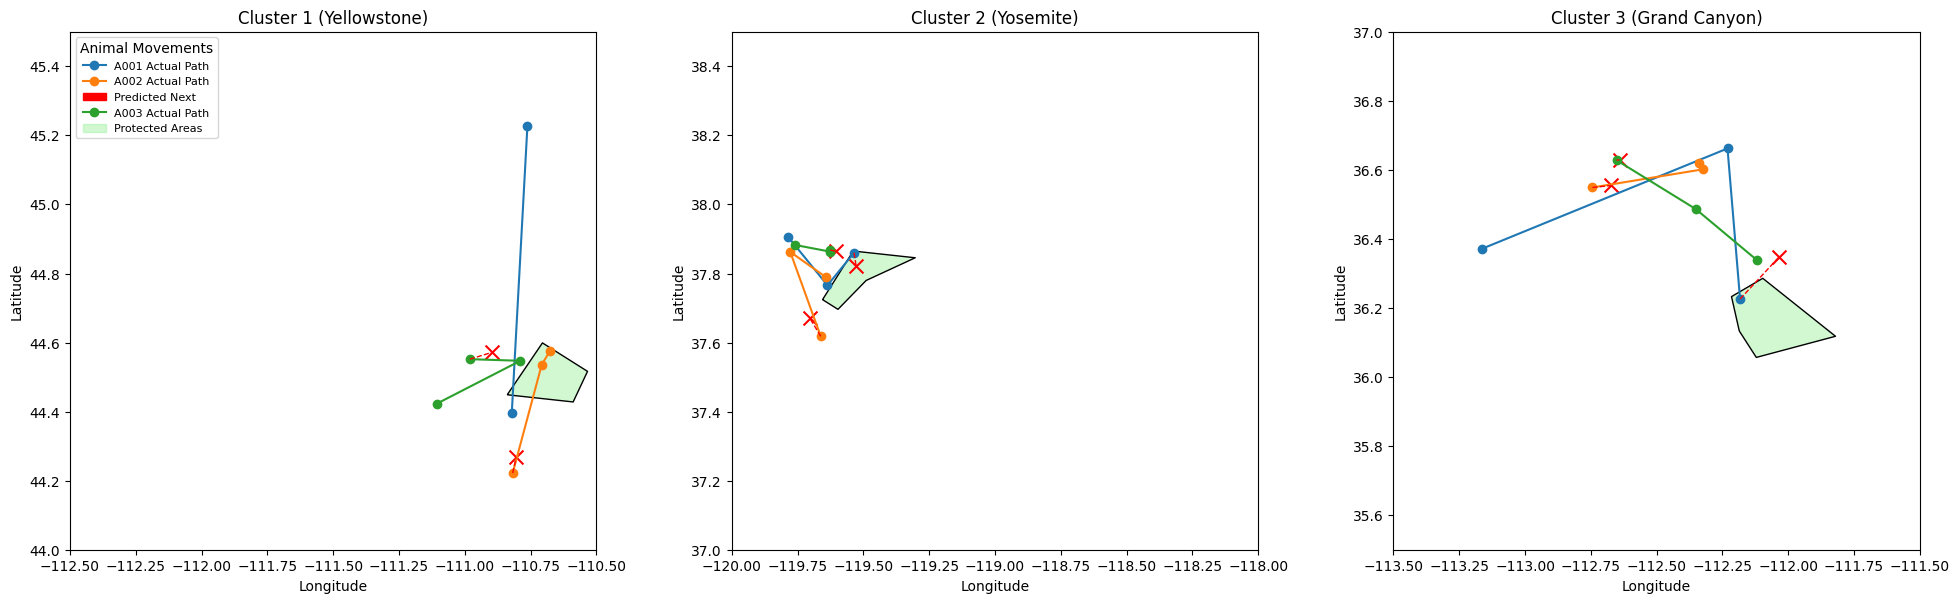

In [11]:
# Dictionary to store actual and predicted movements for each animal
animal_paths_all = {}

# Iterate over each animal_id in the entire dataset
for animal_id, group in animal_events_gdf.groupby('animal_id'):
    # Extract features and target variables
    group = group.sort_values(by='timestamp')  # Ensure chronological order
    group['hour'] = group['timestamp'].dt.hour
    group['month'] = group['timestamp'].dt.month
    
    # Prepare features for regression
    X = group[['hour', 'month']]
    y = np.vstack(group['geometry'].apply(lambda point: [point.x, point.y]))  # Combine longitude and latitude into 2D array

    # Initialize and train the 2D linear regression model
    model = MultiOutputRegressor(LinearRegression())

    if len(group) > 1:  # Fit the model if there are enough data points
        model.fit(X, y)

        # Predict the next point using the most recent data point
        next_point_features = pd.DataFrame([[group['hour'].iloc[-1], group['month'].iloc[-1]]], columns=['hour', 'month'])  # Convert to DataFrame with correct feature names
        next_point_prediction = model.predict(next_point_features)

        next_lon, next_lat = next_point_prediction[0]  # Extract predicted longitude and latitude

        # Store the actual and predicted paths
        animal_paths_all[animal_id] = {
            'actual_lon': y[:, 0],  # Longitudes
            'actual_lat': y[:, 1],  # Latitudes
            'predicted_lon': next_lon,
            'predicted_lat': next_lat
        }

# Define the coordinate ranges for each cluster to zoom in on
cluster_ranges = [
    {'xlim': (-112.5, -110.5), 'ylim': (44.0, 45.5), 'title': 'Cluster 1 (Yellowstone)'},
    {'xlim': (-120.0, -118.0), 'ylim': (37.0, 38.5), 'title': 'Cluster 2 (Yosemite)'},
    {'xlim': (-113.5, -111.5), 'ylim': (35.5, 37.0), 'title': 'Cluster 3 (Grand Canyon)'}
]

# Create subplots for each cluster
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# Plot each cluster
for i, cluster in enumerate(cluster_ranges):
    ax = axs[i]

    # Plot protected areas
    protected_areas_gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    protected_areas_gdf.plot(ax=ax, color='lightgreen', alpha=0.4)  # Don't set label here to avoid the warning

    # Plot each animal's actual path and predicted next movement within the cluster bounds
    for animal_id, path_data in animal_paths_all.items():
        # Filter to plot only points within the current cluster bounds
        actual_points_in_cluster = (
            (path_data['actual_lon'] >= cluster['xlim'][0]) & (path_data['actual_lon'] <= cluster['xlim'][1]) &
            (path_data['actual_lat'] >= cluster['ylim'][0]) & (path_data['actual_lat'] <= cluster['ylim'][1])
        )
        
        # Plot the actual path within the cluster
        if np.any(actual_points_in_cluster):  # Check if there are any points within the cluster
            ax.plot(
                path_data['actual_lon'][actual_points_in_cluster],
                path_data['actual_lat'][actual_points_in_cluster],
                marker='o', label=f'{animal_id} Actual Path'
            )
        
        # Check if the predicted next movement falls within the cluster
        if (cluster['xlim'][0] <= path_data['predicted_lon'] <= cluster['xlim'][1]) and \
           (cluster['ylim'][0] <= path_data['predicted_lat'] <= cluster['ylim'][1]):
            last_lon = path_data['actual_lon'][-1]
            last_lat = path_data['actual_lat'][-1]
            ax.plot(
                [last_lon, path_data['predicted_lon']],
                [last_lat, path_data['predicted_lat']],
                color='red', linestyle='--', linewidth=1
            )
            # Plot the predicted point
            ax.scatter(
                path_data['predicted_lon'], path_data['predicted_lat'],
                color='red', marker='x', label='Predicted Next', s=100
            )
            
    # Set the limits and title for each subplot
    ax.set_xlim(cluster['xlim'])
    ax.set_ylim(cluster['ylim'])
    ax.set_title(cluster['title'])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Create custom legend handles
protected_area_patch = mpatches.Patch(color='lightgreen', label='Protected Areas', alpha=0.4)
predicted_next_patch = mpatches.Patch(color='red', label='Predicted Next')

# Collect and deduplicate legend labels
handles, labels = axs[0].get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Remove duplicates

# Add custom legend handles for protected areas and predicted next
unique_labels['Protected Areas'] = protected_area_patch
unique_labels['Predicted Next'] = predicted_next_patch

# Add the combined legend to the first subplot
axs[0].legend(handles=unique_labels.values(), loc='upper left', fontsize=8, title='Animal Movements')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

#### Analysis

Cluster 1 (Yellowstone)
- The proximity of predicted next locations near the protected area boundary suggests that animals may frequently migrate toward or away from the protected region. This could indicate that the protected area serves as a central habitat or a safe zone, but animals might roam outside temporarily for foraging or other behaviors.

Cluster 2 (Yosemite)
- The animal movements in Yosemite show a relatively dense clustering of movements around the protected area boundary. The predicted next movements show animals staying close to the protected area and may not venture far from the protected zone, possibly due to its resources or as a refuge from external threats. This indicates that the protected area is an essential habitat, and animals might be reliant on the resources within or near the boundary.

Cluster 3 (Grand Canyon)
- Animal movements are more dispersed, with some animals predicted to move further away from the protected area. However, some predicted next points are still near the protected boundary. Animal behavior in the Grand Canyon shows more variability in movement patterns. Some animals are predicted to move away from the protected area, indicating that the animals might use the protected zone as part of a larger migration route. However, the protected area remains significant, as many predicted points still remain close to the boundary, indicating some animals may return or stay near the park.
